In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#import matplotlib.font_manager
%matplotlib inline
#import scipy.ndimage
#from scipy.ndimage.filters import maximum_filter
#import scipy.optimize as opt
#from scipy import stats
from sklearn.cluster import KMeans, DBSCAN
import pymc3 as pm
import arviz as az
import hyperspy.api as hs
#import time
#import math
import os
from IPython.display import clear_output
from mylib.user_func import detect_peaks, twoD_Gaussian, centroid, gauss, generate_cmap

## 1. Load image and set parameters

In [3]:
# Parameter
model = "Gaussian"       # "CoM" or "Gaussian"
size_peak_search = 20    # pix size of ROI for peak search
size_peak = 20           # pix size of ROI for Gaussian (or CoM) fitting
threshold = 0.4         # Minimun threshold of peak intensity against maximun intensity of image
edge = 1               # region (edge * size_peak) where peak is ignored
n_iter = 6               # Number of loops for Gaussian fit
eps = 3                  # DBSCANのパラメータ
ratio = 20               # Magnification of arrows in displacement map
#calibration = 14.451       # pm/pix(ARM_1K)
#calibration = 7.208       # pm/pix(ARM_2K)
#calibration = 12.102       # pm/pix(spectra_1K)
calibration = 10       # pm/pix(spectra_2K)
display_sigma = 3        # グラフに表示する誤差の大きさ(1: 68%, 2: 95%, 3: 99.7%)
scan_distortion = 0    # スキャン影響による変位決定精度の誤差(1標準偏差) [pm]
input_file = "SrTiO3_simu_intensity50.dm4"
output_dir = "JEOL"
FWHM = size_peak/2       # Initial value of FWHM for Gaussian fitting

# Import an image
cur_dir = os.getcwd()    # Get filepath of current directory
if os.name == "nt":      # If os is Windows
    data_dir = os.path.dirname(cur_dir) + "\\data"
    ds = hs.load(data_dir + "\\" + input_file)
if os.name == "posix":   # If os is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data"
    ds = hs.load(data_dir + "//" + input_file)      
s = hs.signals.Signal1D(ds)
ydim, xdim, = s.data.shape
Z = np.flipud(s.data)    # Flip vertically because dm4 has inverse definition of y-axis against matplotlib

## 2. Detect peaks roughly

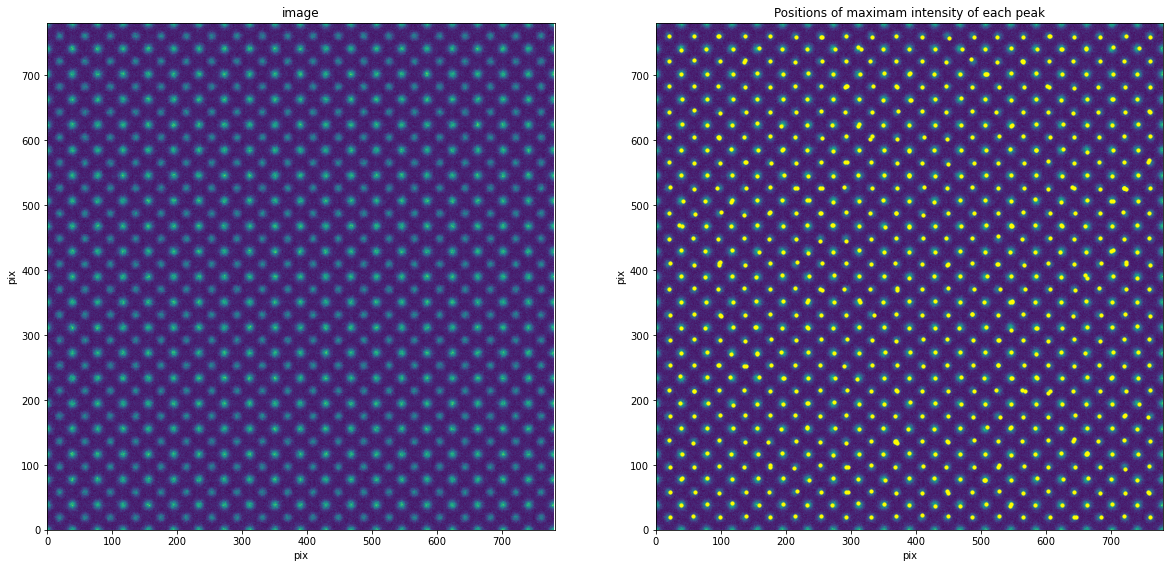

In [4]:
# Search peaks roughly
peaks_maximam = detect_peaks(Z, edge, filter_size=size_peak_search, order=threshold)

# Make plots
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(Z, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)
ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_maximam[1], peaks_maximam[0], s=10, c="yellow", marker="o")
ax2.set_title("Positions of maximam intensity of each peak")
ax2.set_xlabel("pix")
ax2.set_ylabel("pix")
ax2.set_xlim(0, xdim)
ax2.set_ylim(0, ydim)
plt.show()

## 3. Remove outliers

In [ ]:
# Make plots
fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(111)
ax.imshow(Z, origin="lower")
ax.scatter(peaks_maximam[1], peaks_maximam[0], s=10, c="yellow", marker="o")
for i in range(len(peaks_maximam[0])):
    ax.text(peaks_maximam[1][i], peaks_maximam[0][i], str(i), color="white", fontsize=10)
ax.set_title("Positions of maximam intensity of each peak")
ax.set_xlabel("pix")
ax.set_ylabel("pix")
ax.set_xlim(0, xdim)
ax.set_ylim(0, ydim)
plt.show()

In [35]:
# 削除したい輝点の番号をoutliersにリスト形式で指定。このセルを実行後、1つ前のセルに戻って指定した輝点が削除されていることを確認。
# まだ消したい輝点が残っていた場合は繰り返す。
#outliers = [181, 165, 162, 176, 189, 183, 168, 163, 171, 166, 172, 173]
#outliers = [170, 174]
#outliers = [168]
outliers = [0, 1, 109, 319]

#outliers = [76, 60, 57, 71, 84, 63, 78, 58, 66, 61, 80, 74, 67, 68]
#outliers = [63]
#outliers = [68]

#outliers = [186, 201]

# 指定した輝点の削除
peaks_maximam = np.delete(peaks_maximam, outliers, 1)

In [6]:
# Peak detection
min_samples = int((xdim/size_peak)/2*0.6)   # Lower threshold on cluster formation factors in DBSCAN clustering
#min_samples = 15

# Clustering by DBSCAN
peaks_x = peaks_maximam[1]
peaks_y = peaks_maximam[0]
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(np.reshape(peaks_y, [-1, 1]))
labels = dbscan_model.labels_ + 1
col = max(labels)
inlier_peaks_x = peaks_x[~(labels == 0)]
inlier_peaks_y = peaks_y[~(labels == 0)]
cluster_centers = np.array([np.average(peaks_y[(labels == i)]) for i in range(col) ])
labels = labels[~(labels == 0)] - 1

print("Number of peaks = {0}".format(len(peaks_maximam[0])))
print("Number of rows = {0}".format(col))
print("Number of atoms in rows = {0}".format(int(len(labels)/col)))
print("Minimun limit in rows = {0}".format(min_samples*2))

Number of peaks = 865
Number of rows = 39
Number of atoms in rows = 22
Minimun limit in rows = 22


c:\Users\nomura\Anaconda3\envs\pm3\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\nomura\Anaconda3\envs\pm3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## 4. Peak fit using simple 2D Gaussian

Number of peaks = 865 ⇒ 763


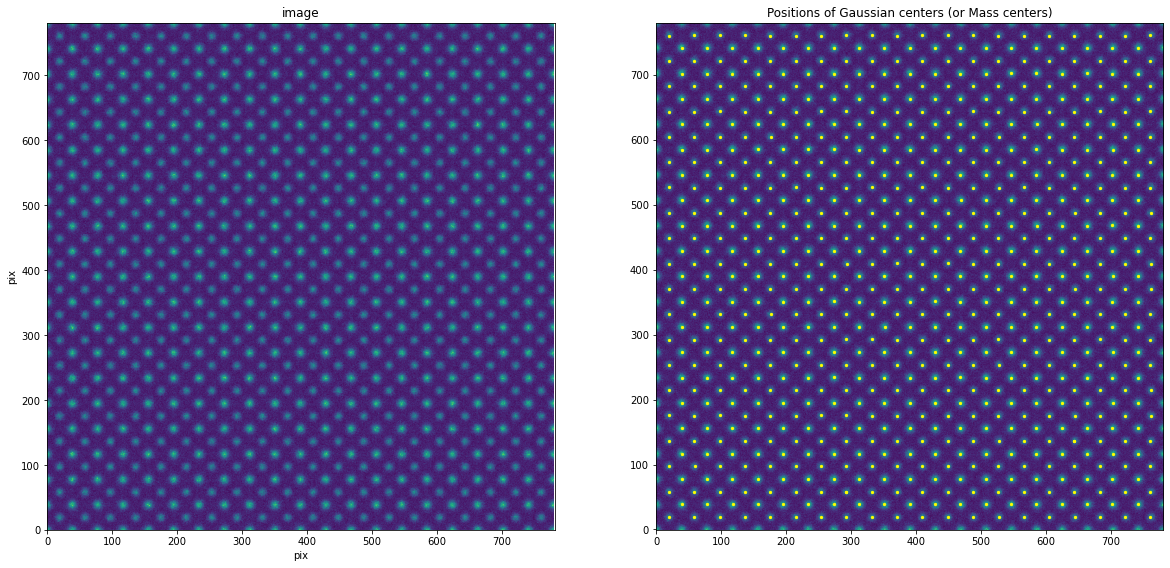

In [7]:
# Fit 2D gaussian
fit_method = "simple"

# Calculate atomic positions
peaks = set([])
for h in range(len(peaks_y)):
    px = peaks_x[h]
    py = peaks_y[h]
    for i in range(n_iter):
        if model == "CoM": cx,cy = centroid(Z[int(round(py-size_peak/2)):int(round(py+size_peak/2)), int(round(px-size_peak/2)):int(round(px+size_peak/2))])
        if model == "Gaussian": cx,cy = gauss(Z[int(round(py-size_peak/2)):int(round(py+size_peak/2)), int(round(px-size_peak/2)):int(round(px+size_peak/2))], size_peak, FWHM)
        px = round(px-size_peak/2)+cx
        py = round(py-size_peak/2)+cy
    peaks.add((px, py))
peaks_x = [ x for x, y in peaks ]
peaks_y = [ y for x, y in peaks ]
print("Number of peaks = {0} ⇒ {1}".format(len(peaks_maximam[0]), len(peaks)))

# Make plots
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(Z, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)
ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_x, peaks_y, s=5, c="yellow", marker="o")
ax2.set_title("Positions of Gaussian centers (or Mass centers)")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)
plt.show()

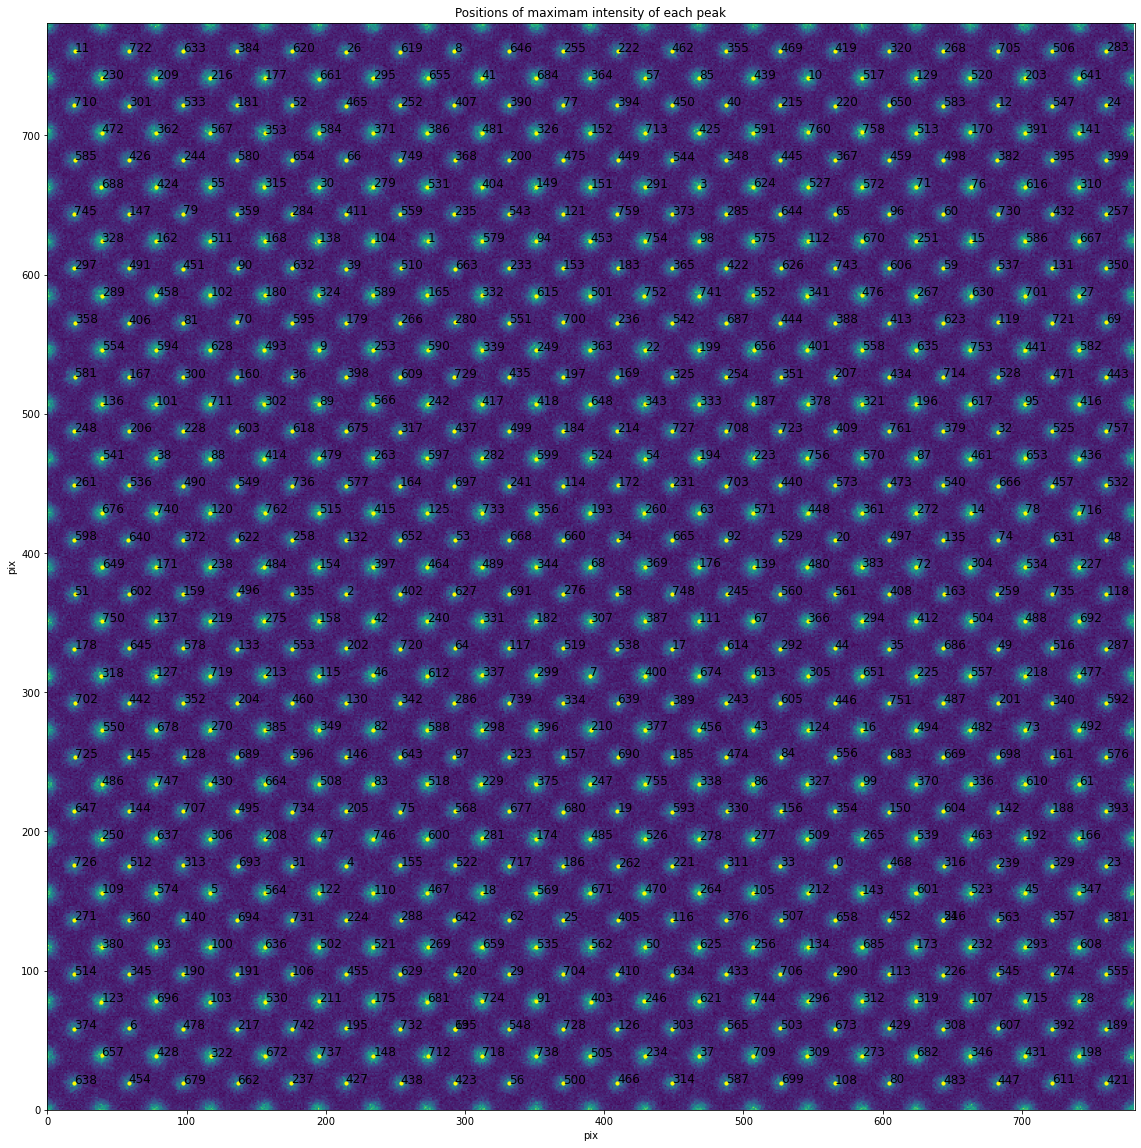

In [8]:
# Make plots

outliers = []

peaks_x = np.delete(peaks_x, outliers)
peaks_y = np.delete(peaks_y, outliers)

fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(111)
ax.imshow(Z, origin="lower")
ax.scatter(peaks_x, peaks_y, s=10, c="yellow", marker="o")
for i in range(len(peaks_x)):
    ax.text(peaks_x[i], peaks_y[i], str(i), color="black", fontsize=12)
ax.set_title("Positions of maximam intensity of each peak")
ax.set_xlabel("pix")
ax.set_ylabel("pix")
ax.set_xlim(0, xdim)
ax.set_ylim(0, ydim)
plt.show()

## 5. Peak fit using 2D Gaussian with Bayesian inference

In [ ]:
#Model(Uniform bachground)
fit_method = "bayes"

#Make x-y grating
x_linspace = np.linspace(0, size_peak-1, size_peak)
y_linspace = np.linspace(0, size_peak-1, size_peak)
x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)
x_coords = x_grid.ravel()
y_coords = y_grid.ravel()
xy_coords = np.stack((x_coords, y_coords), axis=0).T    #pymcの構造に合わせて転置
peaks_x_bayes = np.zeros_like(peaks_x)
peaks_y_bayes = np.zeros_like(peaks_y)
sd_x_bayes = np.zeros_like(peaks_x)
sd_y_bayes = np.zeros_like(peaks_y)
summary = []

for i in range(len(peaks)):
    print("Bayesian Inference of atomic position: " + str(i+1) + "/" + str(len(peaks)))
    patch = Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))]
    with pm.Model() as model:
        xy = pm.Data('Coordinate', xy_coords)
        mu = pm.Uniform('Atom Position (μ)', lower=0, upper=size_peak, shape=2)
        sigma = pm.Uniform('Noise (σ)', lower=0, upper=np.max(patch.ravel()))
        bckgrd = pm.Uniform('Background Intensity', lower=0, upper=np.mean(patch.ravel()))
        peak = pm.Uniform('Peak Intensity', lower=0, upper=np.max(patch.ravel())*2)
        sd_dist = pm.Exponential.dist(1)
        packed_chol = pm.LKJCholeskyCov("Cholesky Matrix", n=2, eta=1, sd_dist=sd_dist, compute_corr=False)
        chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
        cov = pm.Deterministic('Covariance Matrix', chol.dot(chol.T))
        inv =  pm.math.matrix_inverse(cov)
        y = pm.Normal('Intensity', mu=(np.exp( -pm.math.extract_diag(pm.math.matrix_dot((xy-mu), inv, (xy-mu).T))/2.0)) * peak + bckgrd, sigma=sigma, observed=patch.ravel())
        
    #MCMC Sampling
    with model:
        trace = pm.sample(
            draws=6000,
            tune=3000,
            chains=3,
            return_inferencedata=True
        )

    summary.append(az.summary(trace))
    mean_vars = az.summary(trace).loc[["Atom Position (μ)[0]", "Atom Position (μ)[1]"], "mean"]
    sd_vars = az.summary(trace).loc[["Atom Position (μ)[0]", "Atom Position (μ)[1]"], "sd"]
    peaks_x[i] = mean_vars[0] + round(peaks_x[i]-size_peak/2)
    peaks_y[i] = mean_vars[1] + round(peaks_y[i]-size_peak/2)
    sd_x_bayes[i] = sd_vars[0]
    sd_y_bayes[i] = sd_vars[1]
    
    #clear_output(True)    #outputセルのクリア
    
    print(az.summary(trace))

Bayesian Inference of atomic position: 1/2117


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 74 seconds.
INFO:pymc3:Sampling 3 chains for 3_000 tune and 6_000 draw iterations (9_000 + 18_000 draws total) took 74 seconds.


                               mean        sd      hdi_3%     hdi_97%  \
Atom Position (μ)[0]          6.314     0.023       6.272       6.357   
Atom Position (μ)[1]          5.668     0.023       5.625       5.713   
Noise (σ)                  4084.417   252.297    3611.362    4560.777   
Background Intensity      21556.613   698.026   20265.319   22880.760   
Peak Intensity           144710.034  1480.433  141979.757  147554.593   
Cholesky Matrix[0]            2.234     0.030       2.179       2.290   
Cholesky Matrix[1]           -0.000     0.033      -0.060       0.062   
Cholesky Matrix[2]            2.257     0.030       2.200       2.314   
Covariance Matrix[0, 0]       4.991     0.132       4.742       5.237   
Covariance Matrix[0, 1]      -0.001     0.073      -0.135       0.139   
Covariance Matrix[1, 0]      -0.001     0.073      -0.135       0.139   
Covariance Matrix[1, 1]       5.098     0.137       4.835       5.351   

                         mcse_mean  mcse_sd  ess_b

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...


In [23]:
# ベイズ推定結果の確認
pd.options.display.precision = 2
summary_df = pd.DataFrame([], index=[i for i in range(len(peaks))], columns=["Mean-x [pix]", "Mean-y [pix]", "SD-x [pix]", "SD-y [pix]", "r_hat"])
for i in range(len(peaks)):
    summary_df.loc[i, "Mean-x [pix]"] = summary[i].loc["Atom Position (μ)[0]", "mean"]
    summary_df.loc[i, "Mean-y [pix]"] = summary[i].loc["Atom Position (μ)[1]", "mean"]
    summary_df.loc[i, "SD-x [pix]"] = summary[i].loc["Atom Position (μ)[0]", "sd"]
    summary_df.loc[i, "SD-y [pix]"] = summary[i].loc["Atom Position (μ)[1]", "sd"]
    summary_df.loc[i, "r_hat"] = summary[i].loc["Atom Position (μ)[0]", "r_hat"]

In [ ]:
pd.set_option("display.max_rows", len(summary_df))
summary_df

## 6. Analysis for Pervskite crystal

In [8]:
# Clustering
kmeans_model = KMeans(n_clusters=col).fit(np.reshape(peaks_y, [-1, 1]))    # Kmeans法を用いて輝点を行ごとに分類(y座標の値で判定)
labels = kmeans_model.labels_
cluster_centers = kmeans_model.cluster_centers_                            # 各行の原子カラムのy座標の代表値を"cluster_centers"に格納。"cluster_centers"の要素数は行数と同じ
cluster_centers = np.array([ e for row in cluster_centers for e in row ])  # "cluster_centers"を1次元ベクトルに展開

# Align factors
cluster_index = { k:v for k,v in enumerate(cluster_centers.argsort()) }    # "cluster_index"は"cluster_centers"の各要素が、何番目に小さいかを示している。「0:8」であれば、"cluster_centers"の要素0は9番目に小さい(下から9行目の原子カラム列)
align_peaks_x = np.array( [ np.array(peaks_x)[np.where(labels == cluster_index[h])] for h in range(col) ], dtype='object' )         # "peaks_x"の値を小さい順に各行ごとに取り出してndarray化
align_peaks_y = np.array( [ np.array(peaks_y)[np.where(labels == cluster_index[h])] for h in range(col) ], dtype='object' )         # "peaks_y"の値を小さい順に各行ごとに取り出してndarray化
if fit_method == "bayes":
    align_sd_x = np.array( [ np.array(sd_x_bayes)[np.where(labels == cluster_index[h])] for h in range(col) ], dtype='object' )
    align_sd_y = np.array( [ np.array(sd_y_bayes)[np.where(labels == cluster_index[h])] for h in range(col) ], dtype='object' )
x_index = [ { k:v for k,v in enumerate(align_peaks_x[h].argsort()) } for h in range(col) ]                          # 各行内の原子カラムを小さい順に並べるために各要素が何番目に小さいかを辞書化(上と同じことを各行で実施)。
align_peaks_x =  [ [ align_peaks_x[h][x_index[h][i]] for i in range(len(align_peaks_x[h])) ] for h in range(col) ]  # 各行の"peaks_x"の値を小さい順に取り出してndarray化
align_peaks_y =  [ [ align_peaks_y[h][x_index[h][i]] for i in range(len(align_peaks_x[h])) ] for h in range(col) ]  # 各行の"peaks_x"の値を小さい順に取り出してndarray化
if fit_method == "bayes":
    align_sd_x = [ [ align_sd_x[h][x_index[h][i]] for i in range(len(align_sd_x[h])) ] for h in range(col) ]
    align_sd_y = [ [ align_sd_y[h][x_index[h][i]] for i in range(len(align_sd_x[h])) ] for h in range(col) ]
# ここまででピーク座標を縦横小さい順に並べ替えた

flat_align_peaks_x = [ e for row in align_peaks_x for e in row ]
flat_align_peaks_y = [ e for row in align_peaks_y for e in row ]
if fit_method == "bayes":
    flat_align_sd_x = [ e for row in align_sd_x for e in row ]
    flat_align_sd_y = [ e for row in align_sd_y for e in row ]

# Define bottom row as Sr aor Ti
row_1 = [ Z[int(y), int(x)] for (x,y) in zip(align_peaks_x[0], align_peaks_y[0]) ]    #1番下の行の原子カラム中心のピクセル強度を取得
row_2 = [ Z[int(y), int(x)] for (x,y) in zip(align_peaks_x[1], align_peaks_y[1]) ]    #下から2行目の原子カラム中心のピクセル強度を取得
ave_row_1 = sum(row_1)/len(row_1)              # 1番下の行の原子カラム中心の平均強度を取得
ave_row_2 = sum(row_2)/len(row_2)              # 下から2番目の行の原子カラム中心の平均強度を取得
if ave_row_1 > ave_row_2: bottom_row = "Sr"    # 一番下の原子カラムの行がSr
if ave_row_1 < ave_row_2: bottom_row = "Ti"    # 一番下の原子カラムの行がTi

# Define left column as Sr or Ti
if bottom_row == "Sr":
    if align_peaks_x[0][0] < align_peaks_x[1][0]:
        left_col = "Sr"
    else:
        left_col = "Ti"

if bottom_row == "Ti":
    if align_peaks_x[0][0] < align_peaks_x[1][0]:
        left_col = "Ti"
    else:
        left_col = "Sr"

# Remove outliers
lst = [ len(align_peaks_x[i]) for i in range(col) ]
lst_even = [ len(align_peaks_x[int(2*i)]) for i in range(int(col/2+col%2)) ]    # 偶数行の原子カラム数を取得(「%」は余り)
lst_odd = [ len(align_peaks_x[int(2*i+1)]) for i in range(int(col/2)) ]         # 奇数行の原子カラム数を取得
min_lst_even = min(lst_even)    #偶数行の最小の原子カラム数を取得
min_lst_odd = min(lst_odd)      #奇数行の最小の原子カラム数を取得

if bottom_row == "Sr":
    index_even = [ 2*i for i,x in enumerate(lst_even) if x != min_lst_even ]    # 偶数行に対して、原子カラム数が他の行より多い行のインデックスを取得
    index_odd = [ 2*i+1 for i,x in enumerate(lst_odd) if x != min_lst_even-1 ]  # 奇数行に対して、原子カラム数が(偶数行の最小-1)より多い行のインデックスを取得
    dif_even = [ lst[i] - min_lst_even for i in index_even ]                    # 偶数行の原子カラムが他の行より多い行に関して、余分な原子カラム数を取得
    dif_odd = [ lst[i] - (min_lst_even-1) for i in index_odd ]                  # 奇数行の原子カラムが(偶数行の最小-1)より多い行に関して、余分な原子カラム数を取得
    min_index_even = np.argmin(np.array(lst_even))*2                            # 偶数行の中で最小の原子カラム数をもつ行のインデックスを取得
    for i,x in enumerate(index_even):
        for j in range(dif_even[i]):
            if abs(align_peaks_x[x][0]-align_peaks_x[min_index_even][0]) > abs(align_peaks_x[x][-1]-align_peaks_x[min_index_even][-1]):    # 余分な原子カラムが右か左かどちらに出ているかを判定。この条件は左に出ている場合
                del align_peaks_x[x][0]                                         # 左端の原子カラムの座標を削除
                del align_peaks_y[x][0]                                         # 左端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][0]                                        # 左端の原子カラムの標準偏差を削除
                    del align_sd_y[x][0]                                        # 左端の原子カラムの標準偏差を削除
            elif abs(align_peaks_x[x][0]-align_peaks_x[min_index_even][0]) < abs(align_peaks_x[x][-1]-align_peaks_x[min_index_even][-1]):  # 余分な原子カラムが右か左かどちらに出ているかを判定。この条件は右に出ている場合
                del align_peaks_x[x][-1]                                        # 右端の原子カラムの座標を削除
                del align_peaks_y[x][-1]                                        # 右端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][-1]                                        #右端の原子カラムの標準偏差を削除
                    del align_sd_y[x][-1]                                        #右端の原子カラムの標準偏差を削除
    for i,x in enumerate(index_odd):
        for j in range(dif_odd[i]):
            if align_peaks_x[x][0] < align_peaks_x[min_index_even][0]:          # 余分な原子カラムが右か左かどちらに出ているかを判定。この条件は左に出ている場合
                del align_peaks_x[x][0]                                         # 左端の原子カラムの座標を削除
                del align_peaks_y[x][0]                                         # 左端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][0]                                        # 左端の原子カラムの標準偏差を削除
                    del align_sd_y[x][0]                                        # 左端の原子カラムの標準偏差を削除
            elif align_peaks_x[x][-1] > align_peaks_x[min_index_even][-1]:      # 余分な原子カラムが右か左かどちらに出ているかを判定。この条件は右に出ている場合
                del align_peaks_x[x][-1]                                        # 右端の原子カラムの座標を削除
                del align_peaks_y[x][-1]                                        # 右端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][-1]                                        #右端の原子カラムの標準偏差を削除
                    del align_sd_y[x][-1]                                        #右端の原子カラムの標準偏差を削除
elif bottom_row == "Ti":
    index_even = [ 2*i for i,x in enumerate(lst_even) if x != min_lst_odd-1 ]   # 偶数行に対して、原子カラム数が(奇数行の最小-1)より多い行のインデックスを取得
    index_odd = [ 2*i+1 for i,x in enumerate(lst_odd) if x != min_lst_odd ]     # 奇数行に対して、原子カラム数が他の行より多い行のインデックスを取得
    dif_even = [ lst[i] - (min_lst_even-1) for i in index_even ]                # 偶数行の原子カラムが(奇数行の最小-1)より多い行に関して、余分な原子カラム数を取得
    dif_odd = [ lst[i] - min_lst_even for i in index_odd ]                      # 奇数行の原子カラムが他の行より多い行に関して、余分な原子カラム数を取得
    min_index_odd = np.argmin(np.array(lst_odd))*2+1                            # 奇数行の中で最小の原子カラム数をもつ行のインデックスを取得
    for i,x in enumerate(index_even):
        for j in range(dif_even[i]):
            if align_peaks_x[x][0] < align_peaks_x[min_index_odd][0]:           # 余分な原子カラムが右か左かどちらに出ているかを判定。この条件は左に出ている場合
                del align_peaks_x[x][0]                                         # 左端の原子カラムの座標を削除
                del align_peaks_y[x][0]                                         # 左端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][0]                                        # 左原子カラムの座標を削除
                    del align_sd_y[x][0]                                        # 左子カラムの座標を削除
            elif align_peaks_x[x][-1] > align_peaks_x[min_index_odd][-1]:       # 余分な原子カラムが右か左かどちらに出ているかを判定。左に出ている場合以下を実行
                del align_peaks_x[x][-1]                                        # 右端の原子カラムの座標を削除
                del align_peaks_y[x][-1]                                        # 右端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][-1]                                       # 右端の原子カラムの標準偏差を削除
                    del align_sd_y[x][-1]                                       # 右端の原子カラムの標準偏差を削除
    for i,x in enumerate(index_odd):
        for j in range(dif_odd[i]):
            if abs(align_peaks_x[x][0]-align_peaks_x[min_index_odd][0]) > abs(align_peaks_x[x][-1]-align_peaks_x[min_index_odd][-1]):    # 余分な原子カラムが右か左かどちらに出ているかを判定。この条件は左に出ている場合
                del align_peaks_x[x][0]                                         # 左端の原子カラムの座標を削除
                del align_peaks_y[x][0]                                         # 左端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][0]                                        # 左端の原子カラムの座標を削除
                    del align_sd_y[x][0]                                        # 左端の原子カラムの座標を削除
            elif abs(align_peaks_x[x][0]-align_peaks_x[min_index_odd][0]) < abs(align_peaks_x[x][-1]-align_peaks_x[min_index_odd][-1]):  # 余分な原子カラムが右か左かどちらに出ているかを判定。左に出ている場合以下を実行
                del align_peaks_x[x][-1]                                        # 右端の原子カラムの座標を削除
                del align_peaks_y[x][-1]                                        # 右端の原子カラムの座標を削除
                if fit_method == "bayes":
                    del align_sd_x[x][-1]                                       # 右原子カラムの標準偏差を削除
                    del align_sd_y[x][-1]                                       # 右原子カラムの標準偏差を削除

# Calculate atomic displacement
if bottom_row == "Sr":
    if left_col == "Sr":
        center_x = np.array([ [ (align_peaks_x[h*2][i]+align_peaks_x[h*2][i+1]+align_peaks_x[h*2+2][i]+align_peaks_x[h*2+2][i+1])/4 for i in range(len(align_peaks_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # x座標の重心の計算
        center_y = np.array([ [ (align_peaks_y[h*2][i]+align_peaks_y[h*2][i+1]+align_peaks_y[h*2+2][i]+align_peaks_y[h*2+2][i+1])/4 for i in range(len(align_peaks_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # y座標の重心の計算
        distance_x = [ align_peaks_x[i*2+1] for i in range(int(col/2-1+col%2)) ] - center_x    # x座標に関して、Srカラムの重心とTiカラムの差分を計算 
        distance_y = [ align_peaks_y[i*2+1] for i in range(int(col/2-1+col%2)) ] - center_y    # y座標に関して、Srカラムの重心とTiカラムの差分を計算
    elif left_col == "Ti":
        center_x = np.array([ [ (align_peaks_x[h*2][i]+align_peaks_x[h*2][i+1]+align_peaks_x[h*2+2][i]+align_peaks_x[h*2+2][i+1])/4 for i in range(len(align_peaks_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # x座標の重心の計算
        center_y = np.array([ [ (align_peaks_y[h*2][i]+align_peaks_y[h*2][i+1]+align_peaks_y[h*2+2][i]+align_peaks_y[h*2+2][i+1])/4 for i in range(len(align_peaks_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # y座標の重心の計算
        distance_x = [ align_peaks_x[i*2+1] for i in range(int(col/2-1+col%2)) ] - center_x    # x座標に関して、Srカラムの重心とTiカラムの差分を計算 
        distance_y = [ align_peaks_y[i*2+1] for i in range(int(col/2-1+col%2)) ] - center_y    # y座標に関して、Srカラムの重心とTiカラムの差分を計算
if bottom_row == "Ti":
    if left_col == "Ti":
        center_x = np.array([ [ (align_peaks_x[h*2+1][i]+align_peaks_x[h*2+1][i+1]+align_peaks_x[h*2+3][i]+align_peaks_x[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # x座標の重心の計算
        center_y = np.array([ [ (align_peaks_y[h*2+1][i]+align_peaks_y[h*2+1][i+1]+align_peaks_y[h*2+3][i]+align_peaks_y[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # y座標の重心の計算
        distance_x = [ align_peaks_x[i*2][:-1] for i in range(1, int(col/2)) ] - center_x         # x座標に関して、Srカラムの重心とTiカラムの差分を計算
        distance_y = [ align_peaks_y[i*2][:-1] for i in range(1, int(col/2)) ] - center_y         # y座標に関して、Srカラムの重心とTiカラムの差分を計算
    elif left_col == "Sr":
        center_x = np.array([ [ (align_peaks_x[h*2+1][i]+align_peaks_x[h*2+1][i+1]+align_peaks_x[h*2+3][i]+align_peaks_x[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # x座標の重心の計算
        center_y = np.array([ [ (align_peaks_y[h*2+1][i]+align_peaks_y[h*2+1][i+1]+align_peaks_y[h*2+3][i]+align_peaks_y[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # y座標の重心の計算
        distance_x = [ align_peaks_x[i*2] for i in range(1, int(col/2)) ] - center_x         # x座標に関して、Srカラムの重心とTiカラムの差分を計算
        distance_y = [ align_peaks_y[i*2] for i in range(1, int(col/2)) ] - center_y         # y座標に関して、Srカラムの重心とTiカラムの差分を計算       

flat_center_x = [ e for row in center_x for e in row ]        # 1次元ベクトル化
flat_center_y = [ e for row in center_y for e in row ]        # 1次元ベクトル化
flat_distance_x = [ e for row in distance_x for e in row ]    # 1次元ベクトル化
flat_distance_y = [ e for row in distance_y for e in row ]    # 1次元ベクトル化
distances = [ ((x**2)+(y**2))**(1/2) for (x,y) in zip(flat_distance_x, flat_distance_y) ]

# Calcurate errors for each unit cell
if fit_method == "bayes":
    if bottom_row == "Sr":
        if left_col == "Sr":
            sd_average_x = np.array([ [ (align_sd_x[h*2][i]+align_sd_x[h*2][i+1]+align_sd_x[h*2+2][i]+align_sd_x[h*2+2][i+1])/4 for i in range(len(align_sd_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # x座標の標準偏差の平均の計算
            sd_average_y = np.array([ [ (align_sd_y[h*2][i]+align_sd_y[h*2][i+1]+align_sd_y[h*2+2][i]+align_sd_y[h*2+2][i+1])/4 for i in range(len(align_sd_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # y座標の標準偏差の平均の計算
            sd_sum_x = [ align_sd_x[i*2+1] for i in range(int(col/2-1+col%2)) ] + sd_average_x    # x座標に関して、4つのSrカラムの標準偏差の平均とTiカラムの標準偏差の和を計算 
            sd_sum_y = [ align_sd_y[i*2+1] for i in range(int(col/2-1+col%2)) ] + sd_average_y    # y座標に関して、4つのSrカラムの標準偏差の平均とTiカラムの標準偏差の和を計算
        elif left_col == "Ti":
            sd_average_x = np.array([ [ (align_sd_x[h*2][i]+align_sd_x[h*2][i+1]+align_sd_x[h*2+2][i]+align_sd_x[h*2+2][i+1])/4 for i in range(len(align_sd_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # x座標の標準偏差の平均の計算
            sd_average_y = np.array([ [ (align_sd_y[h*2][i]+align_sd_y[h*2][i+1]+align_sd_y[h*2+2][i]+align_sd_y[h*2+2][i+1])/4 for i in range(len(align_sd_x[h*2])-1) ] for h in range(int(col/2-1+col%2)) ])    # y座標の標準偏差の平均の計算
            sd_sum_x = [ align_sd_x[i*2+1] for i in range(int(col/2-1+col%2)) ] + sd_average_x    # x座標に関して、Srカラムの重心とTiカラムの差分を計算 
            sd_sum_y = [ align_sd_y[i*2+1] for i in range(int(col/2-1+col%2)) ] + sd_average_y    # y座標に関して、Srカラムの重心とTiカラムの差分を計算
    if bottom_row == "Ti":
        if left_col == "Ti":
            sd_average_x = np.array([ [ (align_sd_x[h*2+1][i]+align_sd_x[h*2+1][i+1]+align_sd_x[h*2+3][i]+align_sd_x[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # x座標の標準偏差の平均の計算
            sd_average_y = np.array([ [ (align_sd_y[h*2+1][i]+align_sd_y[h*2+1][i+1]+align_sd_y[h*2+3][i]+align_sd_y[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # y座標の標準偏差の平均の計算
            sd_sum_x = [ align_sd_x[i*2][:-1] for i in range(1, int(col/2)) ] + sd_average_x         # x座標に関して、Srカラムの重心とTiカラムの差分を計算
            sd_sum_y = [ align_sd_y[i*2][:-1] for i in range(1, int(col/2)) ] + sd_average_y         # y座標に関して、Srカラムの重心とTiカラムの差分を計算
        elif left_col == "Sr":
            sd_average_x = np.array([ [ (align_sd_x[h*2+1][i]+align_sd_x[h*2+1][i+1]+align_sd_x[h*2+3][i]+align_sd_x[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # x座標の標準偏差の平均の計算
            sd_average_y = np.array([ [ (align_sd_y[h*2+1][i]+align_sd_y[h*2+1][i+1]+align_sd_y[h*2+3][i]+align_sd_y[h*2+3][i+1])/4 for i in range(len(align_peaks_x[h*2+1])-1) ] for h in range(int(col/2-1)) ])    # y座標の標準偏差の平均の計算
            sd_sum_x = [ align_sd_x[i*2] for i in range(1, int(col/2)) ] + sd_average_x         # x座標に関して、Srカラムの重心とTiカラムの差分を計算
            sd_sum_y = [ align_sd_y[i*2] for i in range(1, int(col/2)) ] + sd_average_y         # y座標に関して、Srカラムの重心とTiカラムの差分を計算       
    flat_sd_x = [ e for row in sd_sum_x for e in row ]        # 1次元ベクトル化
    flat_sd_y = [ e for row in sd_sum_y for e in row ]        # 1次元ベクトル化

## 7. Make Plots

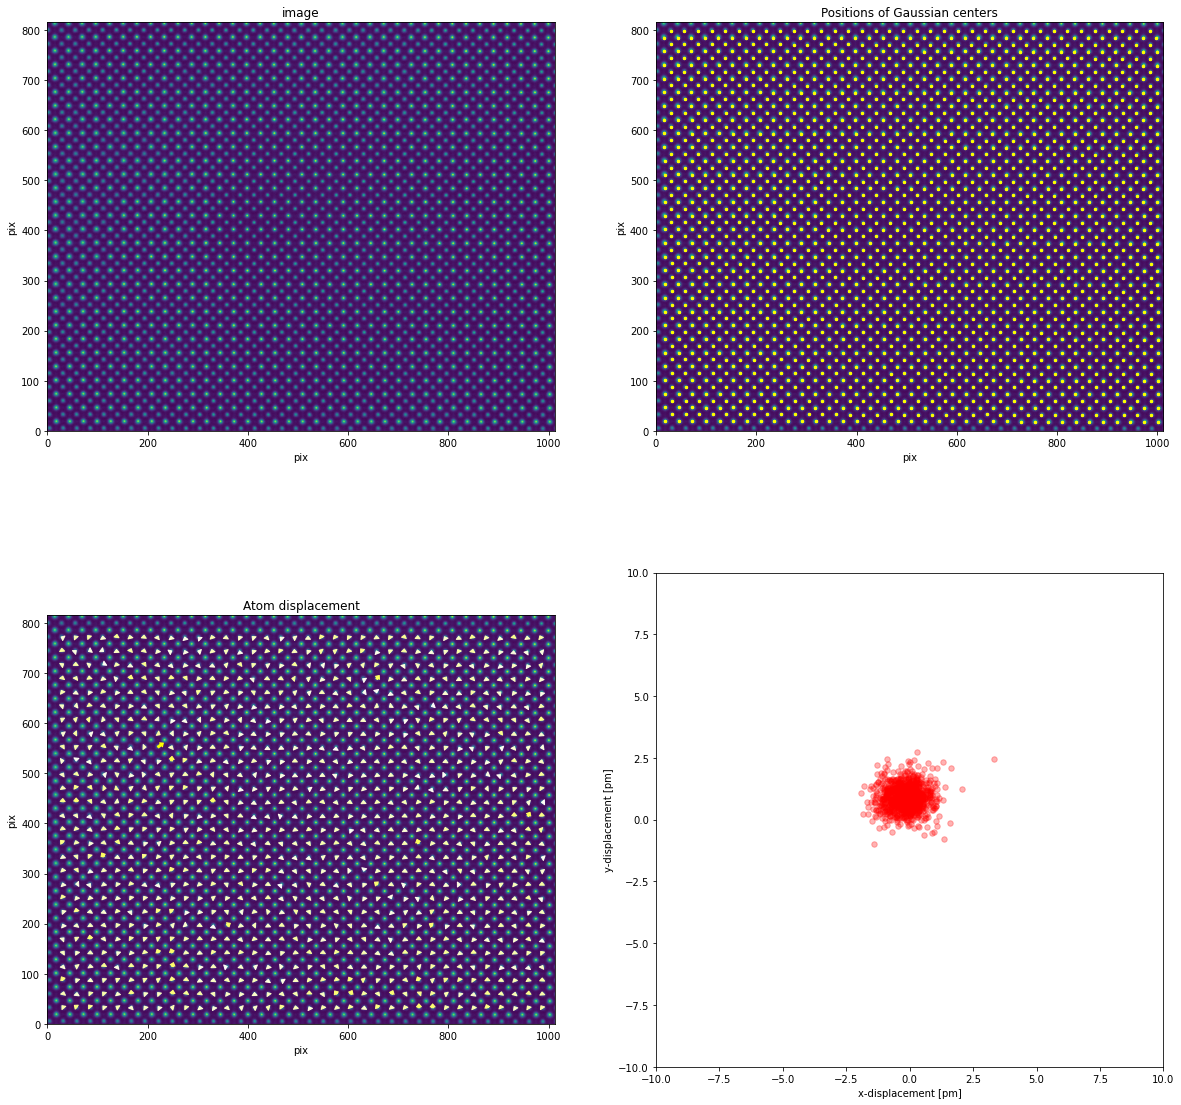

Mean of displacement [pm] = (-0.17, 0.90)
Standard deviation(x, y) of displacement [pm] = (0.56, 0.49)
Standard deviation(kobayashi) of displacement [pm] = (0.46)


In [9]:
# 矢印のカラーを定義
cm = generate_cmap(['white', 'yellow'])
color = np.array([ distances[i]/sorted(distances)[-1] for i in range(len(flat_distance_x))])
color = np.where(color>=1, 0.99, color)
color = cm(color)
                  
# Make plots
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(Z, origin="lower")
ax1.set_title("image")
ax1.set_xlabel("pix")
ax1.set_ylabel("pix")
ax1.set_xlim(0, xdim)
ax1.set_ylim(0, ydim)

ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_x, peaks_y, s=5, c="yellow", marker="o")
ax2.set_title("Positions of Gaussian centers (or Mass centers)")

ax2.imshow(Z, origin="lower")
ax2.scatter(peaks_x, peaks_y, s=5, c="yellow", marker="o")
if fit_method == "bayes":
    for i in range(len(flat_align_peaks_x)):
        # ベイズ推定で計算したTi変位誤差を円で記述(円の半径：[Srカラム4つの誤差の平均とTiカラムの誤差の和]×[拡大率]×[確率(1σ(68.3%) or 2σ(95.5%) or 3σ(99.7%))]。2はpatches.Ellipseの引数は直径のため)
        ax2.add_patch(patches.Ellipse(xy=(flat_align_peaks_x[i], flat_align_peaks_y[i]), width= flat_align_sd_x[i]*ratio*2*display_sigma, height= flat_align_sd_y[i]*ratio*2*display_sigma, angle=0, color="red", alpha=0.5))
if fit_method == "simple": ax2.set_title("Positions of Gaussian centers")
elif fit_method == "bayes": ax2.set_title("Atomic positions with error")
ax2.set_xlabel("pix")
ax2.set_ylabel("pix")
ax2.set_xlim(0, xdim)
ax2.set_ylim(0, ydim)
ax3.imshow(Z, origin="lower")
for i in range(len(flat_distance_x)):
#    ax3.annotate('', xy=[flat_center_x[i] + flat_distance_x[i]*ratio/2, flat_center_y[i]+flat_distance_y[i]*ratio/2], xytext=[flat_center_x[i]-flat_distance_x[i]*ratio/2, flat_center_y[i]-flat_distance_y[i]*ratio/2], arrowprops=dict(shrink=0, width=2, headwidth=5, headlength=3,
#                 connectionstyle='arc3', facecolor=color[i], edgecolor=color[i]))    #"xy"が終点、"xytext"が始点
    ax3.annotate('', xy=[ flat_center_x[i] + flat_distance_x[i]*ratio, flat_center_y[i] + flat_distance_y[i]*ratio ], xytext=[flat_center_x[i], flat_center_y[i]], arrowprops=dict(shrink=0, width=2, headwidth=5, headlength=3,
                 connectionstyle='arc3', facecolor=color[i], edgecolor=color[i]))    #"xy"が終点、"xytext"が始点
    if fit_method == "bayes":
        # ベイズ推定で計算したTi変位誤差を円で記述(円の半径：[Srカラム4つの誤差の平均とTiカラムの誤差の和]×[拡大率]×[確率(1σ(68.3%) or 2σ(95.5%) or 3σ(99.7%))]。2はpatches.Ellipseの引数は直径のため)
        ax3.add_patch(patches.Ellipse(xy=(flat_center_x[i], flat_center_y[i]), width= flat_sd_x[i]*ratio*2*display_sigma, height= flat_sd_y[i]*ratio*2*display_sigma, angle=0, color="red", alpha=0.5))
        ax3.add_patch(patches.Ellipse(xy=(flat_center_x[i], flat_center_y[i]), width=(flat_sd_x[i]+scan_distortion/calibration)*2*ratio*display_sigma, height=(flat_sd_y[i]+scan_distortion/calibration)*2*ratio*display_sigma, angle=0, color="yellow", alpha=0.2))
if fit_method == "simple": ax3.set_title("Atom displacement")
elif fit_method == "bayes": ax3.set_title("Atom displacement with error")
ax3.set_xlabel("pix")
ax3.set_ylabel("pix")
ax3.set_xlim(0, xdim)
ax3.set_ylim(0, ydim)
ax4.scatter(np.array(flat_distance_x)*calibration, np.array(flat_distance_y)*calibration, s=30, c="red", marker="o", alpha=0.3)
ax4.set_xlabel("x-displacement [pm]")
ax4.set_ylabel("y-displacement [pm]")
ax4.set_xlim(-sorted(distances)[-1], sorted(distances)[-1])
ax4.set_ylim(-sorted(distances)[-1], sorted(distances)[-1])
ax4.set_xlim(-10, 10)
ax4.set_ylim(-10, 10)
plt.show()

#変位の平均と標準偏差の表示
std_x = np.std(np.array(flat_distance_x))*calibration
std_y = np.std(np.array(flat_distance_y))*calibration
flat_distance = np.sqrt(np.array(flat_distance_x)**2 + np.array(flat_distance_y)**2)*calibration
kobayashi_std = np.std(flat_distance)

print("Mean of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.mean(np.array(flat_distance_x))*calibration, np.mean(np.array(flat_distance_y))*calibration))
print("Standard deviation(x, y) of displacement [pm] = ({0:.2f}, {1:.2f})".format(std_x, std_y))
print("Standard deviation(kobayashi) of displacement [pm] = ({0:.2f})".format(kobayashi_std))
#print("Standard deviation of displacement [pm] = ({0:.2f}, {1:.2f})".format(np.std(np.array(distances))*calibration))

## 8. Save/Load results of Bayesian inference

In [25]:
#「Peak fit using 2D Gaussian with Bayesian inference」を実行 ⇒ このセルを実行

# save results of Bayesian inference
if os.name == "nt":      # If os is Windows
    out_dir = os.path.dirname(cur_dir) + "\\data\\" + output_dir 
    os.mkdir(out_dir)
    out_dir += "\\"
if os.name == "posix":   # If os is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data//" + output_dir
    os.mkdir(out_dir)
    out_dir += "//"
np.save(out_dir + "STEM_image.npy", Z)
np.save(out_dir + "summary.npy", summary)
summary_df.to_csv(out_dir + "summary_df.csv")
summary_df.to_pickle(out_dir + "summary_df.pkl")
np.save(out_dir + "Bayes_peaks-x.npy", peaks_x)
np.save(out_dir + "Bayes_peaks-y.npy", peaks_y)
np.save(out_dir + "Bayes_sd-x.npy", sd_x_bayes)
np.save(out_dir + "Bayes_sd-y.npy", sd_y_bayes)

In [103]:
# 「Peak fit using simple 2D Gaussian」まで実行 ⇒ このセルを実行 ⇒ 「Peak fit using 2D Gaussian with Bayesian inference」以下を実行

# load results of Bayesian inference
fit_method = "bayes"
if os.name == "nt":      # If os is Windows
    out_dir = os.path.dirname(cur_dir) + "\\data\\" + output_dir + "\\"
if os.name == "posix":   # If os is Linux or Mac
    data_dir = os.path.dirname(cur_dir) + "//data//" + output_dir + "//"
Z = np.load(out_dir + 'STEM_image.npy')
#summary = np.load(out_dir + 'summary.npy')
summary_df = pd.read_pickle(out_dir + "summary_df.pkl")
peaks_x = np.load(out_dir + 'Bayes_peaks-x.npy')
peaks_y = np.load(out_dir + 'Bayes_peaks-y.npy')
sd_x_bayes = np.load(out_dir + 'Bayes_sd-x.npy')
sd_y_bayes = np.load(out_dir + 'Bayes_sd-y.npy')

## Test

In [9]:
i = 12

#Model(Uniform bachground)
fit_method = "bayes"

#Make x-y grating
x_linspace = np.linspace(0, size_peak-1, size_peak)
y_linspace = np.linspace(0, size_peak-1, size_peak)
x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)
x_coords = x_grid.ravel()
y_coords = y_grid.ravel()
xy_coords = np.stack((x_coords, y_coords), axis=0).T    #pymcの構造に合わせて転置
peaks_x_bayes = np.zeros_like(peaks_x)

print("Bayesian Inference of atomic position: " + str(i+1) + "/" + str(len(peaks)))
#patch = Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))]
patch = Z[int(round(peaks_y[i]-size_peak/2)):int(round(peaks_y[i]+size_peak/2)), int(round(peaks_x[i]-size_peak/2)):int(round(peaks_x[i]+size_peak/2))]
with pm.Model() as model:
    xy = pm.Data('Coordinate', xy_coords)
    mu = pm.Uniform('Atom Position (μ)', lower=0, upper=size_peak, shape=2)
    sigma = pm.Uniform('Noise (σ)', lower=0, upper=np.max(patch.ravel()))
    bckgrd = pm.Uniform('Background Intensity', lower=0, upper=np.mean(patch.ravel()))
    peak = pm.Uniform('Peak Intensity', lower=0, upper=np.max(patch.ravel())*2)
    sd_dist = pm.Exponential.dist(1)
    packed_chol = pm.LKJCholeskyCov("Cholesky Matrix", n=2, eta=1, sd_dist=sd_dist, compute_corr=False)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.Deterministic('Covariance Matrix', chol.dot(chol.T))
    inv =  pm.math.matrix_inverse(cov)
    y = pm.Normal('Intensity', mu=(np.exp( -pm.math.extract_diag(pm.math.matrix_dot((xy-mu), inv, (xy-mu).T))/2.0)) * peak + bckgrd, sigma=sigma, observed=patch.ravel())

#MCMC Sampling
with model:
    trace = pm.sample(
        draws=10000,
        tune=5000,
        chains=3,
        return_inferencedata=True
    )

Bayesian Inference of atomic position: 13/763


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


mean    sd  hdi_3%   hdi_97%  mcse_mean   mcse_sd  \
Atom Position (μ)[0]       8.50  0.03    8.44  8.56e+00   2.00e-03  2.00e-03   
Atom Position (μ)[1]       8.72  0.03    8.65  8.78e+00   3.00e-03  2.00e-03   
Noise (σ)                  8.81  0.34    8.19  9.46e+00   2.40e-02  1.70e-02   
Background Intensity       8.18  3.16    2.49  1.43e+01   6.98e-01  5.25e-01   
Peak Intensity           223.47  2.74  218.71  2.29e+02   5.86e-01  4.20e-01   
Cholesky Matrix[0]         5.43  0.09    5.27  5.60e+00   1.40e-02  1.00e-02   
Cholesky Matrix[1]        -0.09  0.05   -0.18  7.00e-03   4.00e-03  3.00e-03   
Cholesky Matrix[2]         5.36  0.09    5.20  5.54e+00   1.60e-02  1.20e-02   
Covariance Matrix[0, 0]   29.50  0.99   27.73  3.14e+01   1.57e-01  1.12e-01   
Covariance Matrix[0, 1]   -0.49  0.28   -1.03  8.00e-03   2.30e-02  1.60e-02   
Covariance Matrix[1, 0]   -0.49  0.28   -1.03  8.00e-03   2.30e-02  1.60e-02   
Covariance Matrix[1, 1]   28.78  0.99   27.05  3.07e+01   1.72e-01  1.23e-01   

                         ess_bulk  ess_tail  r_hat  
Atom Position (μ)[0]        201.0     245.0   1.03  
Atom Position (μ)[1]        162.0     186.0   1.02  
Noise (σ)                   204.0     462.0   1.01  
Background Intensity         20.0      75.0   1.13  
Peak Intensity               22.0     215.0   1.12  
Cholesky Matrix[0]           41.0     132.0   1.09  
Cholesky Matrix[1]          147.0     204.0   1.03  
Cholesky Matrix[2]           32.0      84.0   1.09  
Covariance Matrix[0, 0]      41.0     132.0   1.09  
Covariance Matrix[0, 1]     149.0     266.0   1.03  
Covariance Matrix[1, 0]     149.0     266.0   1.03  
Covariance Matrix[1, 1]      32.0      84.0   1.09

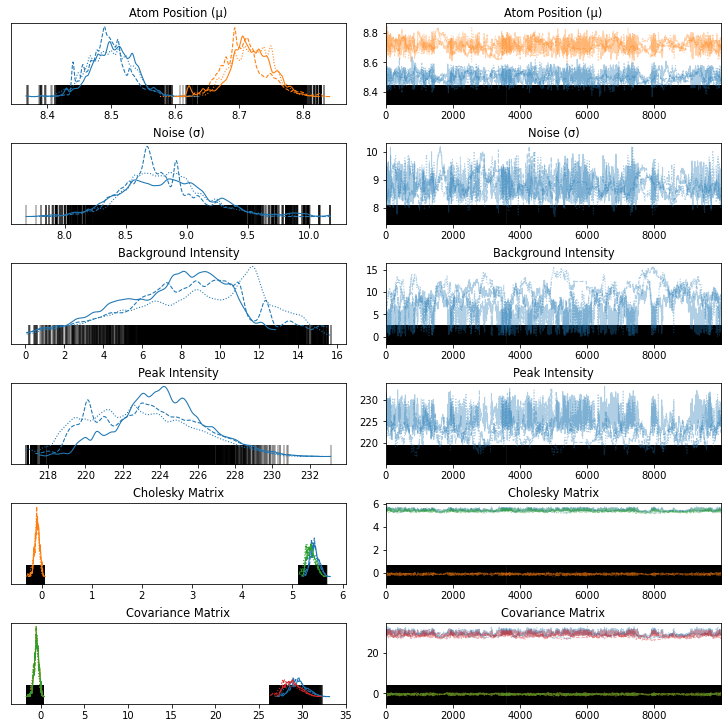

In [20]:
#Display summary
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, figsize=(10,10))
az.summary(trace)

In [21]:
summary[i] = az.summary(trace)
mean_vars = az.summary(trace).loc[["Atom Position (μ)[0]", "Atom Position (μ)[1]"], "mean"]
sd_vars = az.summary(trace).loc[["Atom Position (μ)[0]", "Atom Position (μ)[1]"], "sd"]
peaks_x[i] = mean_vars[0] + round(peaks_x[i]-size_peak/2)
peaks_y[i] = mean_vars[1] + round(peaks_y[i]-size_peak/2)
sd_x_bayes[i] = sd_vars[0]
sd_y_bayes[i] = sd_vars[1]